# t_test On Rehab patient data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [3]:
basmi_df = pd.read_excel('../../data/clean_basmi.xls', index_col=(0,1))

basmi_df = basmi_df.reset_index()[['BS', 'patient_id','Date', 'Drug']]
basmi_df.head()

,BS,patient_id,Date,Drug
0,3.6,40,1995-05-09,NaN
1,4.0,40,1995-06-01,NaN
2,2.6,40,1995-06-12,NaN
3,2.2,40,1995-11-02,NaN
4,2.4,40,1996-05-02,NaN


## Identify rehab patients

* For each patient:
    - calculate difference in measurement date
    - filter on measurements <= 15 and >= 10


In [11]:
def get_rehab(s):
    rehab_date = s[s['Date_diff'] == 14]
    if not rehab_date.empty:
        idx = rehab_date.index.values[0]
        rehab_period = s.loc[idx-1:idx]
        return rehab_period

basmi_df['Date_diff'] = basmi_df['Date'].diff().dt.days

rehab_df = basmi_df.groupby(['patient_id']).apply(get_rehab)

print('{} patients underwent rehab'.format(len(rehab_df['patient_id'].unique())))

rehab_df.reset_index(level=1, drop=True, inplace=True)
rehab_df.drop('patient_id', axis=1, inplace=True)
rehab_df.to_csv('../../data/rehab_data.csv')
rehab_df.head(20)

155 patients underwent rehab


,BS,Date,Drug,Date_diff
patient_id,,,,
43,1.4,2004-09-08,NaN,345.0
43,0.4,2004-09-22,NaN,14.0
44,3.2,1995-07-27,NaN,136.0
44,3.2,1995-08-10,NaN,14.0
46,3.8,2004-07-22,NaN,49.0
46,3.2,2004-08-05,NaN,14.0
54,4.6,2003-06-04,NaN,517.0
54,4.0,2003-06-18,NaN,14.0
59,5.6,1997-04-03,NaN,-6908.0


In [5]:
before = rehab_df.iloc[::2]['BS']
after = rehab_df.iloc[1::2]['BS']

print(len(before))
print(len(after))
before.head()

before = before[:154]

155
154


In [6]:
from scipy import stats

t, p = stats.ttest_ind(before, after)

print('t = {}'.format(t))
print('p = {}'.format(p/2))

t = 4.434264190752112
p = 6.448029677903826e-06


Notice that the test statistic is positive (indicating before - after). Python always performs a two-sided test for symmetrical tests such as the t-test. Therefore, the p-value must be dividd by two to get the one-sided p-value.

/Users/renierbotha/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


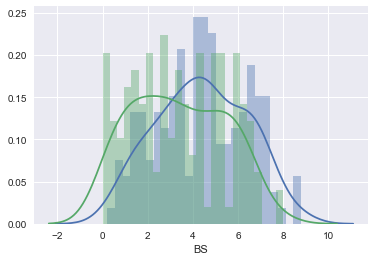

In [7]:
fig = plt.figure()
sns.distplot(before, bins=25)
sns.distplot(after, bins=25)
plt.show()

## Check the assumptions of the t-test. The assumptions are:
    - Both samples are normally distributed
    - Samples are independent

### Visual check for normality: Q-Q plot

We expect a straight line through the origin if the data is normally distributed.

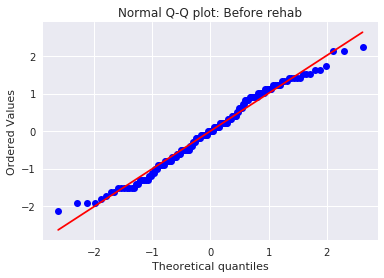

In [9]:
import scipy.stats as stats

Z_before = (before - np.mean(before))/np.std(before)

stats.probplot(Z_before, dist='norm', plot=plt)

plt.title("Normal Q-Q plot: Before rehab")
plt.show()

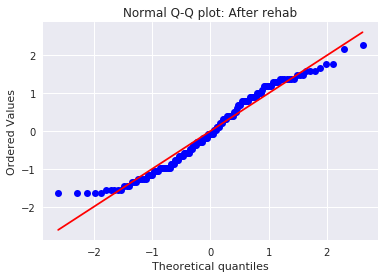

In [10]:
Z_after = (after - np.mean(after))/np.std(after)

stats.probplot(Z_after, dist='norm', plot=plt)

plt.title("Normal Q-Q plot: After rehab")
plt.show()

Notice that the Q-Q plot before the rehab is slightly more normally distributed than after rehab. It seems that the assumption that the data is normally distributed is quite strict - especially for the BS scores of patients after rehab. A similar result is seen from the histograms of the two groups. Next, we perform a formal test for normality (goodness-of-fit test) to see if each group is normally distributed. A well-known test is the Lilliefors test (Kolmogorov Smirnov test). Basically, if $X$ is the random variable with distribution $F$, we test the null hypothesis: $H_{0}: F \tilde{} N(\mu ; \Sigma) $

#### Test for normality for before

In [11]:
D_before,p_before = stats.kstest(before, 'norm')

In [12]:
print('The test statistic is {}'.format(D_before))
print('The p-value is {}'.format(p_before))

The test statistic is 0.867295288818177
The p-value is 0.0


#### Test for normality after

In [15]:
D_after,p_after = stats.kstest(after, 'norm')

In [16]:
print('The test statistic is {}'.format(D_after))
print('The p-value is {}'.format(p_after))

The test statistic is 0.7309316524545406
The p-value is 0.0


It is seen that both tests result in a p-value of zero. Hence, there is sufficient evidence to conclude that the data is not normally distributed. The dependence in the data is now investigated next

### Checking the dependence in the data

In order to see if the data is dependent we consider the coefficient of correlation between the two groups. 

In [17]:
rho, p_rho = stats.pearsonr(before, after)

In [18]:
print('The coefficient of correlation is {}'.format(rho))
print('The p-value for the test for zero correlation is {}'.format(p_rho))

The coefficient of correlation is 0.9426747605494512
The p-value for the test for zero correlation is 2.4450261282112308e-74


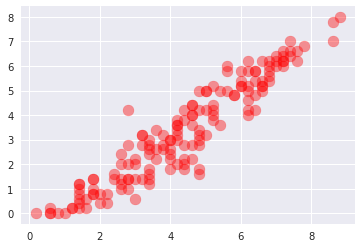

In [19]:
plt.scatter(before, after, alpha =0.4, s=121, color = 'red')

It is seen that the pearson correlation is 0.942 which is extremely high. Furthermore, the test $ H_{0}: \rho = 0 $ vs $H_{a}: \rho \neq 0 $ has a p-value of zero. Hence, there is nearly certainty that the scores before and after rehab are correlated. This is wat is expected given that the scores before and after refer to the same person.

### Paired t-test: Taking into account dependence

In [20]:
t_de, p_de = stats.ttest_rel(before, after)

In [22]:
print('The test statistics is {}'.format(t_de))
print('The p-value is {}'.format(p_de/2))

The test statistics is 18.424353066003054
The p-value is 5.625036977722412e-41


It is seen that even when the dependence is taken into account the p-value is extremely small. This again indicates that the difference between the BS scores before and after rehab differ significantly. 

### Non-parametric test: Taking non-normality into account
We now perform a non-parametric test to compare the means from the before and after rehab group. This test considers the order statistics of the data. The test is known as the Mann Whitney U test or Wilcoxon rank test. Notice we use the continuity correction. 

In [23]:
T_mwu, p_mwu = stats.mannwhitneyu(before, after, use_continuity=True, alternative='greater')

In [25]:
print('The test statistics is {}'.format(T_mwu))
print('The p-value is {}'.format(p_mwu))

The test statistics is 15104.5
The p-value is 1.6213967963023146e-05


It is again observed that the p-value is extremely small. Hence, all tests indicate that the rehab results in a reduced BS score. Therefore, rehab is an effective treatment for the patients.